In [1]:
from __future__ import print_function, absolute_import, division

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt

In [4]:
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [5]:
# For loading NIfTI
import nibabel as nib

In [6]:
# For finding a brain mask from a brain image
from dipy.segment.mask import median_otsu

In [7]:
# Load the FMRI data
img = nib.load('ds114_sub009_t2r1.nii')
data = img.get_data()
data.shape

(64, 64, 30, 173)

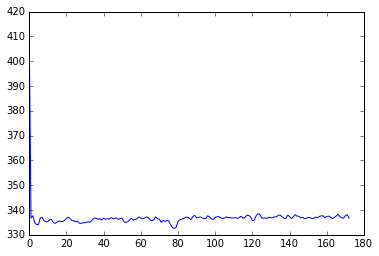

In [8]:
# Global signal plot
time_by_vox = data.reshape((-1, data.shape[-1]))
plt.plot(time_by_vox.mean(axis=0))

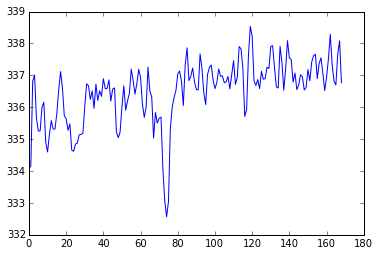

In [9]:
# Knock off first four scans, replot globals
data = data[..., 4:]
n_scans = data.shape[-1]
time_by_vox = data.reshape((-1, n_scans), order='F')
plt.plot(time_by_vox.mean(axis=0))

In [10]:
# Use mean image to extract brain
mean_data = data.mean(axis=-1)
mean_data.shape

(64, 64, 30)

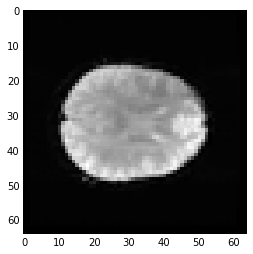

In [11]:
plt.imshow(mean_data[:, :, 15])

In [12]:
# Extract brain with dipy routine
masked, mask = median_otsu(mean_data, 2, 1)

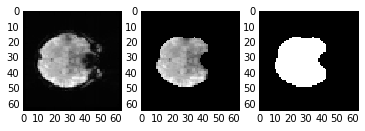

In [13]:
# Show example brain slices
slice_no = 7
fig, axes = plt.subplots(1, 3)
axes[0].imshow(mean_data[:, :, slice_no])
axes[1].imshow(masked[:, :, slice_no])
axes[2].imshow(mask[:, :, slice_no])

In [14]:
# Get in-brain time courses
vox_by_time = data[mask]
vox_by_time.shape

(20931, 169)

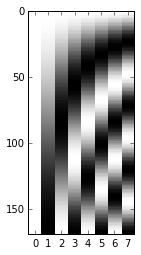

In [15]:
# Make discrete cosine basis set
# See https://en.wikipedia.org/wiki/Discrete_cosine_transform#DCT-II
N = n_scans
n = np.arange(n_scans)
n_plus_half = n + 0.5
dct_basis = np.ones((N, 8))
for k in range(0, 8):
    dct_basis[:, k] = np.cos(np.pi / N * n_plus_half * k)
plt.imshow(dct_basis, aspect=0.1)

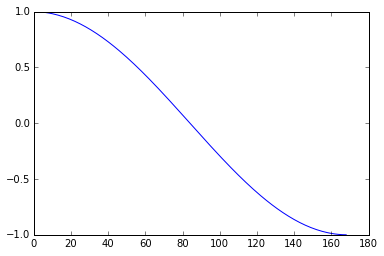

In [16]:
plt.plot(dct_basis[:, 1])

In [17]:
# Project out the the DCT basis
time_by_vox = vox_by_time.T
B_dct = spl.pinv(dct_basis).dot(time_by_vox)
filtered_t_v = time_by_vox - dct_basis.dot(B_dct)

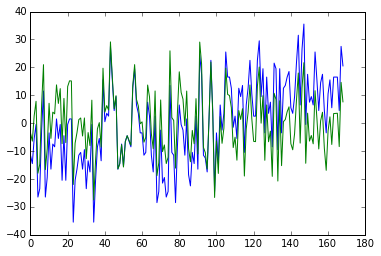

In [18]:
plt.plot(time_by_vox[:, 10000] - time_by_vox[:, 10000].mean())
plt.plot(filtered_t_v[:, 10000])

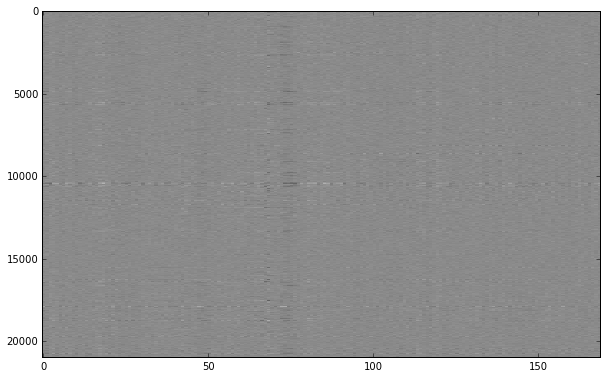

In [19]:
# Do plot similar to Power et al 2013
plt.figure(figsize=(10, 25))
plt.imshow(filtered_t_v.T, aspect=0.005)

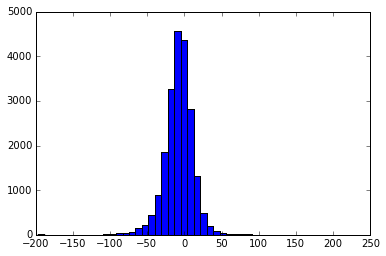

In [20]:
# Plot histogram of all voxel values for first volume
_ = plt.hist(filtered_t_v[0, :], bins=50)

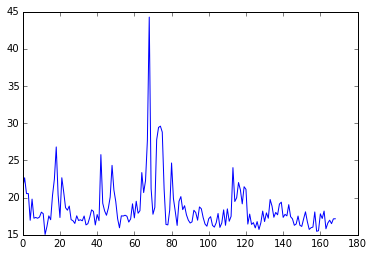

In [21]:
# Are there systematic dips or peaks in variance, shared across voxels?
rms_over_voxels = np.sqrt((filtered_t_v.T ** 2).mean(axis=0))
plt.plot(rms_over_voxels)

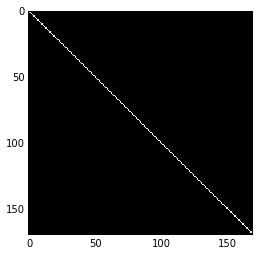

In [22]:
# Make a design matrix with deltas for each scan
X = np.eye(n_scans)
# Demean the columns to make them orthogonal to the mean
X = X - X.mean(axis=0)  # Means all == 1 / nscans
plt.imshow(X)

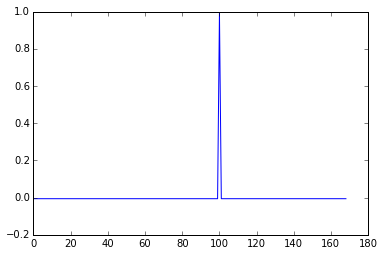

In [23]:
# Each vector is 1 for a single scan, 0 otherwise
plt.plot(X[:, 100])

In [24]:
# Project the data into the space of these deltas
B_dirac = X.T.dot(filtered_t_v)

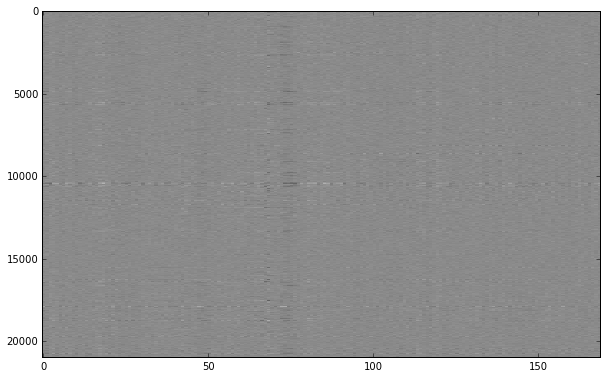

In [25]:
plt.figure(figsize=(10, 25))
plt.imshow(B_dirac.T, aspect=0.005)

From Wikipedia: https://en.wikipedia.org/wiki/Spin%E2%80%93lattice_relaxation

$$
M_z(t) = M_{z,\mathrm{eq}} - \left [ M_{z,\mathrm{eq}} - M_{z}(0) \right ] e^{-t/T_1}
$$

In [26]:
t1_gray_3t = 1.3  # Seconds. Wansapura et al. JMRI 9: 531-538 (1999)
t1_gray_1p5t = 0.920  # Seconds. https://en.wikipedia.org/wiki/Relaxation_(NMR)#T1

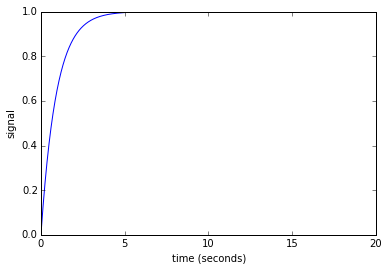

In [27]:
# Plot the T1 effect
Mz_0 = 0
Mz_eq = 1
t = np.linspace(0, 20, 1000)
t1_signal = Mz_eq - (Mz_eq - Mz_0) * np.e ** (-t / t1_gray_1p5t)
plt.plot(t, t1_signal)
plt.xlabel('time (seconds)')
plt.ylabel('signal')

In [28]:
TR = img.header['pixdim'][4]  # Sometimes this is not set correctly
TR

2.5

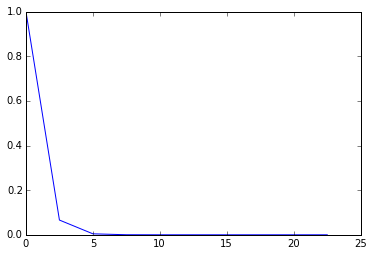

In [29]:
# Make a T1 decay regressor starting at the first scan
t = np.arange(n_scans) * TR
t1_relaxation = np.e ** (-t / t1_gray_1p5t)
plt.plot(t[:10], t1_relaxation[:10])

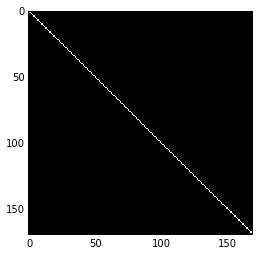

In [30]:
# Make a regressor matrix with this kernel in each column, offset
X_t1 = spl.toeplitz(t1_relaxation, np.zeros(n_scans))
plt.imshow(X_t1)

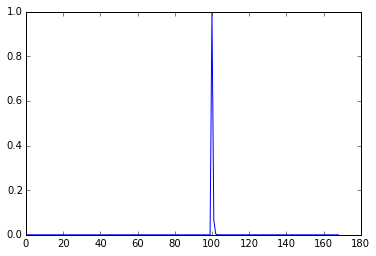

In [31]:
plt.plot(X_t1[:, 100])

In [32]:
# Demean the columns
X_t1 = X_t1 - X_t1.mean(axis=0)

In [33]:
# Project again
B_t1 = X_t1.T.dot(filtered_t_v)

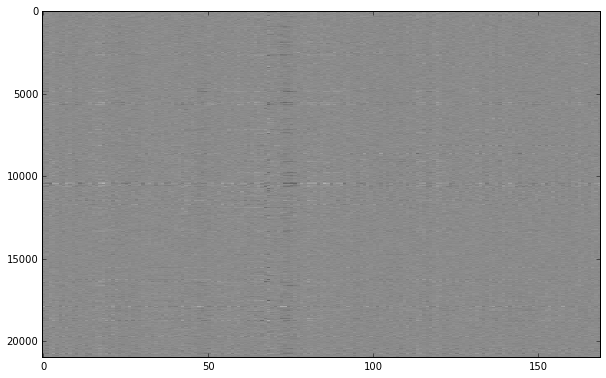

In [34]:
plt.figure(figsize=(10, 25))
plt.imshow(B_t1.T, aspect=0.005)

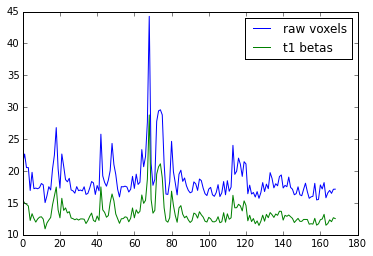

In [35]:
# Are there systematic dips or peaks in these betas across voxels?
rms_over_t1_betas = np.sqrt(B_t1.T ** 2).mean(axis=0)
plt.plot(rms_over_voxels, label='raw voxels')
plt.plot(rms_over_t1_betas, label='t1 betas')
plt.legend()

In [36]:
from sklearn.linear_model import Lasso

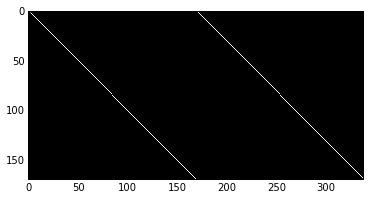

In [37]:
# Make a highly redundant design
big_X = np.hstack((X, X_t1))
plt.imshow(big_X)

In [38]:
# Fit the model
clf = Lasso(alpha = 0.1)
clf.fit(big_X, filtered_t_v)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [39]:
clf.coef_.shape

(20931, 338)

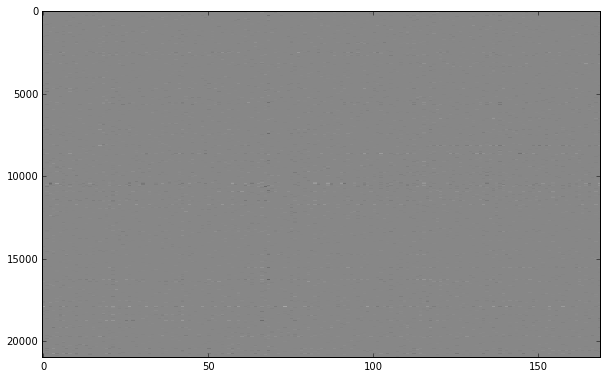

In [40]:
# Show the Dirac coefficients
dirac_coefs = clf.coef_[:, :n_scans]
plt.figure(figsize=(10, 25))
plt.imshow(dirac_coefs, aspect=0.005)

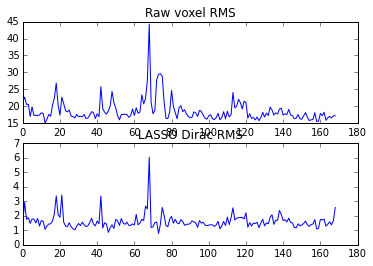

In [41]:
# Are there systematic dips or peaks in these betas across voxels?
rms_over_dirac_coefs = np.sqrt(dirac_coefs ** 2).mean(axis=0)
fig, axes = plt.subplots(2, 1)
axes[0].plot(rms_over_voxels)
axes[0].set_title('Raw voxel RMS')
axes[1].plot(rms_over_dirac_coefs)
axes[1].set_title('LASSO Dirac RMS')

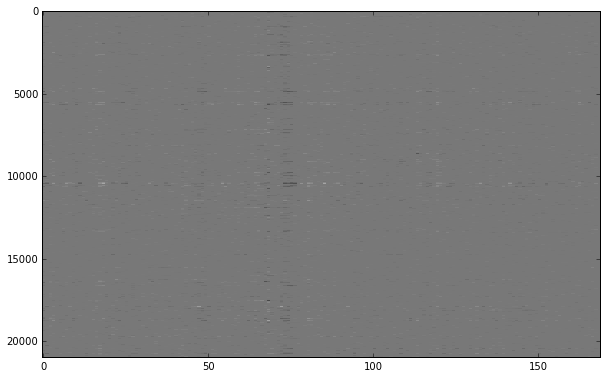

In [42]:
# Show the T1 coefficients
t1_coefs = clf.coef_[:, n_scans:]
plt.figure(figsize=(10, 25))
plt.imshow(t1_coefs, aspect=0.005)

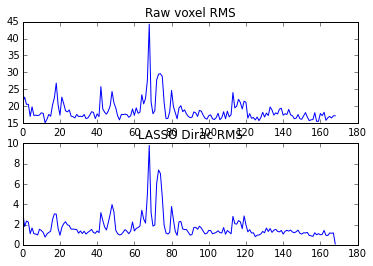

In [43]:
# Are there systematic dips or peaks in these betas across voxels?
rms_over_t1_coefs = np.sqrt(t1_coefs ** 2).mean(axis=0)
fig, axes = plt.subplots(2, 1)
axes[0].plot(rms_over_voxels)
axes[0].set_title('Raw voxel RMS')
axes[1].plot(rms_over_t1_coefs)
axes[1].set_title('LASSO Dirac RMS')